In [1]:
!wget https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/lambda_virus.fa

--2025-11-01 11:18:15--  https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/lambda_virus.fa
Resolving d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)... 3.162.78.162, 3.162.78.8, 3.162.78.122, ...
Connecting to d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)|3.162.78.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49270 (48K) [application/octet-stream]
Saving to: 'lambda_virus.fa'

     0K .......... .......... .......... .......... ........  100% 5.03M=0.009s

2025-11-01 11:18:15 (5.03 MB/s) - 'lambda_virus.fa' saved [49270/49270]



In [2]:
#Function to read Fasta
def ReadGenome(file):
    genome = ''
    with open(file) as f:
        for line in f:
            if not line[0] == '>':
                genome += line.rstrip()
    return genome

In [3]:
genome = ReadGenome('lambda_virus.fa')

In [4]:
#Read Fastq function
def readFastq(filename):
    sequences = []
    qualities = []
    with open(filename) as file:
        while True:
            file.readline()
            seq = file.readline().rstrip()
            file.readline()
            qual = file.readline().rstrip()
            if len(seq) == 0:
                break
            sequences.append(seq)
            qualities.append(qual)
    return sequences, qualities
seqs, quals = readFastq('SRR835775_1.first1000.fastq')

In [5]:
print(seqs[:2])
print(len(max(seqs)))

['TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTCACCCTAACCCTAACCCTAACCGTATCCGTCACCCTAACCCTAAC', 'TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACC']
100


In [6]:
print(quals[:2])

['???B1ADDD8??BB+C?B+:AA883CEE8?C3@DDD3)?D2;DC?8?=BAD=@C@(.6.6=A?=?@##################################', 'CCCFFFFFGHHGHJJJJJIJGIIJJJJJJJIJIJJJJJFJJFGIIIIH=CBFCF=CCEG)=>EHB2@@DEC>;;?=;(=?BBD?59?BA###########']


In [7]:
def phred33toQ(qual):
    return ord(qual) - 33 #ord converts ASCII value to integer number

In [8]:
phred33toQ('#')

2

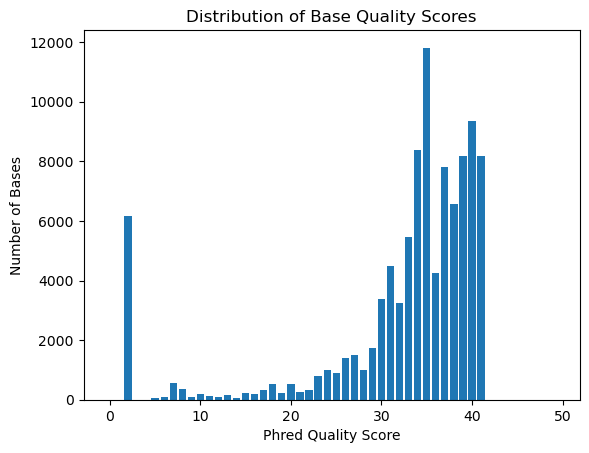

In [9]:
def creatHist(qualities):
    hist = [0]*50
    for qual in qualities:
        for phred in qual:
            q = phred33toQ(phred)
            hist[q] += 1
    return hist
h = creatHist(quals)
#print(h)
import matplotlib.pyplot as plt

plt.bar(range(len(h)), h)
plt.xlabel("Phred Quality Score")        # x-axis label
plt.ylabel("Number of Bases")            # y-axis label
plt.title("Distribution of Base Quality Scores")  # plot title
plt.show()

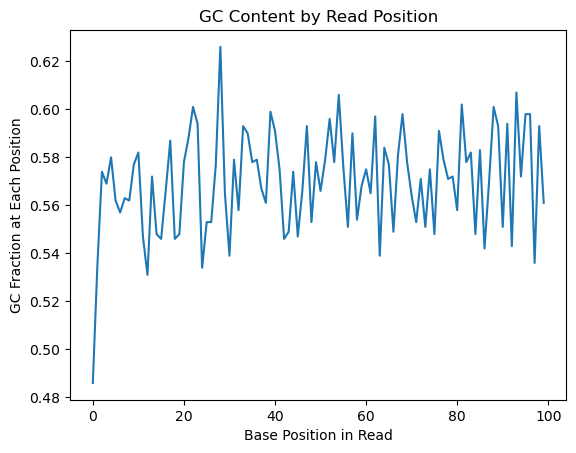

In [10]:
def findGCbypos(reads):
    gc = [0]*100
    totals = [0]*100
    
    for read in reads:
        for i in range(len(read)):
            if read[i] == 'C' or read[i] == 'G':
                gc[i] += 1
            totals[i] += 1
            
    for i in range(len(gc)):
        if totals[i] > 0:
            gc[i] /= float(totals[i])
    return gc

gc = findGCbypos(seqs)
plt.plot(range(len(gc)), gc)
plt.xlabel("Base Position in Read")           
plt.ylabel("GC Fraction at Each Position")           
plt.title("GC Content by Read Position") 
plt.show()

In [11]:
#Function to find the reverse compliment
def Reverse(s):
    compliment = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}
    t = ''
    for i in s:
        t = compliment[i] + t
    return t

In [12]:
#Naive algo to find the occurences of a read in a genome
def naive(p, t):
    occurences = []                            #this list keeps track of all indices where p matches t
    for i in range(len(t) - len(p) + 1):       #loop through every position where p could start
        match = True                           #a boolean variable initialized as True
        for j in range(len(p)):                #compare every character p to its corresponding position t
            if not t[i+j] == p[j]:             #[i+j] ensures same position in t and p are being compared
                match = False
                break
        if match:
            occurences.append(i)
    return occurences

In [13]:
#Modified naive algo to check forward and reverse complements
def naive_with_rc(r, g):
    Rc = Reverse(r)
    matches = naive(r, g)
    rc_matches = []
    if Rc != r:
        rc_matches = naive(Rc, g)     #does not count reads with same reverse compliments
    print('Forward matches: ', len(matches))
    print('Reverse complements: ', len(rc_matches))
    total = list(set(matches + rc_matches))
    print('Total matches: ', len(total))
    return total
#len(matches) 
#matches    AGCT

In [14]:
print(len(naive_with_rc('AGGT', genome)))

Forward matches:  150
Reverse complements:  156
Total matches:  306
306


In [15]:
print(len(naive_with_rc('TTAA', genome)))

Forward matches:  195
Reverse complements:  0
Total matches:  195
195


In [16]:
naive('ACTAAGT', genome)

[27733, 45382]

In [17]:
naive_with_rc('ACTAAGT', genome)

Forward matches:  2
Reverse complements:  1
Total matches:  3


[26028, 27733, 45382]

In [18]:
naive('AGTCGA', genome)

[18005, 23320, 33657, 44806]

In [19]:
naive_with_rc('AGTCGA', genome)

Forward matches:  4
Reverse complements:  5
Total matches:  9


[450, 44806, 41927, 2472, 45369, 1908, 18005, 23320, 33657]

In [20]:
#Naive exact matching allowing up to max_mismatches mismatches.


def naive_2mm(p, t, max_mismatches=2):

    occurrences = []
    
    for i in range(len(t) - len(p) + 1):
        mismatches = 0
        for j in range(len(p)):
            if t[i + j] != p[j]:
                mismatches += 1
                if mismatches > max_mismatches:
                    break
        if mismatches <= max_mismatches:
            occurrences.append(i)
    
    return occurrences

In [23]:
p = "AGGAGGTT"
occurences = naive_2mm(p, genome)
print(len(occurences))

215
